In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization,Dropout, Conv1D, Conv1DTranspose, MaxPooling1D
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils 
from tensorflow.keras.datasets import mnist, fashion_mnist 
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from PIL import Image 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
import pandas as pd
import os #
from google.colab import drive
import time, random
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
drive.mount('/content/drive/') # монтируем google диск

Mounted at /content/drive/


Создание автокоировщиков для удаления шума

In [ ]:
!unzip -q '/content/drive/MyDrive/Базы/Лица.zip' # распоковываем базу с лицами с google диска в colaboratory

In [ ]:
images_dir = 'Лица' # зададим имя папки в которую распоковали изображения
img_height = 112 # зададим высоту изображений
img_width = 80 # зададим ширину избражений

In [ ]:
# функция загрузки изображений, на вход принемает имя папки с изображениями, высоту и ширину к которой будут преобразованы загружаемые изображения
def load_images(images_dir, img_height, img_width): 
  list_images = [] # создаем пустой список в который будем загружать изображения
  for img in os.listdir(images_dir): # получим список изображений и для каждого изображения
  # добавим в список изображение в виде массива, с заданными размерами, в отенках серого
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  return np.array(list_images) # возвращаем numpy массив загруженных избражений

In [ ]:
xTrain_imag = load_images(images_dir, img_height, img_width) # загрузим избражения лиц

In [ ]:
xTrain_img = xTrain_imag/255 # отнормируем изображения от 0 до 1

In [ ]:
xTrain_img.shape # выведем размерность массива

(5018, 112, 80, 1)

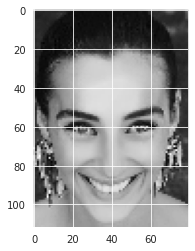

In [ ]:
plt.imshow(xTrain_img[np.random.randint(0, xTrain_img.shape[0])].reshape(112,80), cmap='gray') #выведем случайное изображение
plt.show()

In [ ]:
def addNoise(x, noiseVal): # объявим функцию добавления шума
  #noise = np.random.sample((x.shape[0],28,28,1))
  noise = np.random.normal(loc=0.5, scale=0.5, size=x.shape) # создаем шум(с центром в 0.5 и отклонением 0.5)
  
  # Cкладываем с произведением шума*на усилитель шума и вводим ограничение значений от 0 до 1(clip)
  return np.clip(x + noiseVal * noise, 0., 1.) 

In [ ]:
noisedXTrainFace = addNoise(xTrain_img, 0.35) # cоздаем зашумленный вариант лиц из xTrain_img

In [ ]:
def plotImages(xTrain, pred, shape=(112, 80)): # создадим функцию для вывода изображений как картинок
  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(14, 7)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

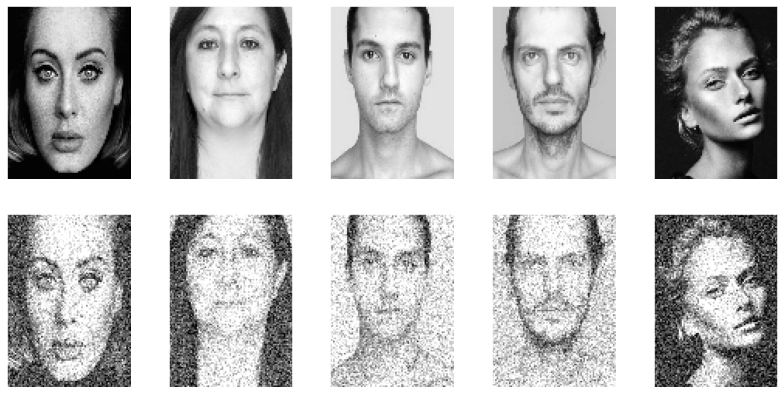

In [ ]:
plotImages(xTrain_img, noisedXTrainFace) # выведем на экран исходные лица и зашумленные варианты 

In [ ]:
def denoiseAutoencoder(): # объявляем функцию создания автокодировщика для подавления шума
    img_input = Input((112,80,1)) # задаём входные размеры

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # пропускаем через слой нормализации данных 
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)  # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    z = MaxPooling2D()(x) # передаём на слой подвыборки
    

    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) # слой разжимает данные(с 28*20 на 56*40)
    x = BatchNormalization()(x) # слой нормализации данных
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    # Сжатие MaxPooling2D не применяем

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 56*40 на 112*80)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # собрали модель с зашумленной картинкой на вход и с очищенной от шума на выход
    model.compile(optimizer='adam',
                  loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки

    return model # функция вернет модель подавления шума



modelDenoiseFace = denoiseAutoencoder()
modelDenoiseFace.summary()



Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 112, 80, 1)]      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 112, 80, 64)       640       
_________________________________________________________________
batch_normalization_20 (Batc (None, 112, 80, 64)       256       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 112, 80, 64)       36928     
_________________________________________________________________
batch_normalization_21 (Batc (None, 112, 80, 64)       256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 56, 40, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 56, 40, 128)       7385

In [ ]:
modelDenoiseFace = denoiseAutoencoder()
# Подаем на вход зашумленные картинки, а на выход правильные, исходные картинки, и обучаем
best__loss = ModelCheckpoint('best_loss.h5', save_best_only=True, monitor='val_loss', mode='min')
history = modelDenoiseFace.fit(noisedXTrainFace[:4700], xTrain_img[:4700], epochs=180, batch_size=100, validation_data = (noisedXTrainFace[4700:], xTrain_img[4700:]), callbacks=[best__loss])

Epoch 1/180
47/47 [==============================] - 23s 377ms/step - loss: 0.0324 - val_loss: 0.0659
Epoch 2/180
47/47 [==============================] - 17s 366ms/step - loss: 0.0047 - val_loss: 0.0642
Epoch 3/180
47/47 [==============================] - 17s 369ms/step - loss: 0.0042 - val_loss: 0.0578
Epoch 4/180
47/47 [==============================] - 18s 373ms/step - loss: 0.0039 - val_loss: 0.0543
Epoch 5/180
47/47 [==============================] - 18s 376ms/step - loss: 0.0039 - val_loss: 0.0493
Epoch 6/180
47/47 [==============================] - 18s 378ms/step - loss: 0.0037 - val_loss: 0.0428
Epoch 7/180
47/47 [==============================] - 18s 375ms/step - loss: 0.0042 - val_loss: 0.0321
Epoch 8/180
47/47 [==============================] - 18s 375ms/step - loss: 0.0037 - val_loss: 0.0254
Epoch 9/180
47/47 [==============================] - 18s 375ms/step - loss: 0.0034 - val_loss: 0.0246
Epoch 10/180
47/47 [==============================] - 18s 375ms/step - loss: 0.003

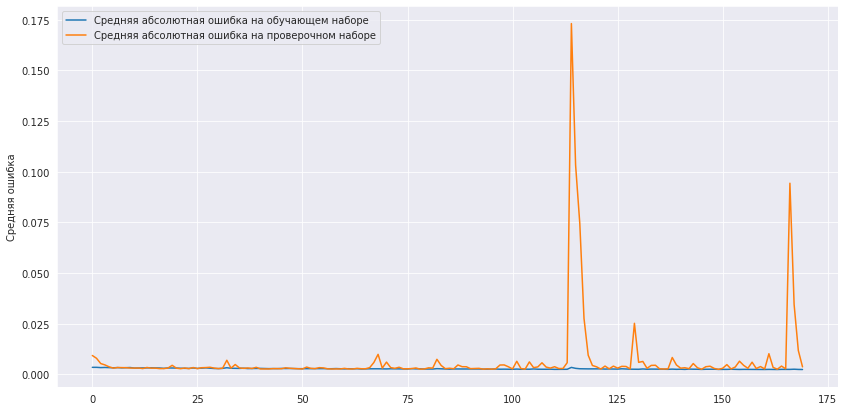

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
modelDenoiseFace = load_model('/content/best_loss.h5')

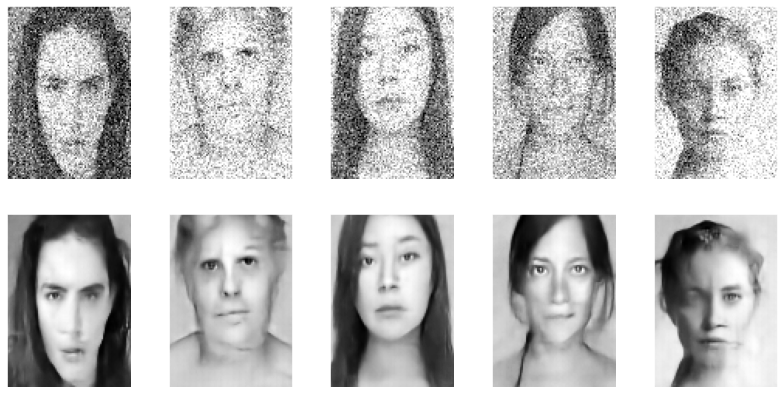

In [ ]:
predTrain = modelDenoiseFace.predict(noisedXTrainFace[:4700]) 
predTrain = predTrain * 255 # представляем в виде значений от 0 до 255
predTrain = predTrain.astype('uint8') # устанавливаем 8битовый тип

plotImages(noisedXTrainFace[:4700], predTrain, shape=(112,80))

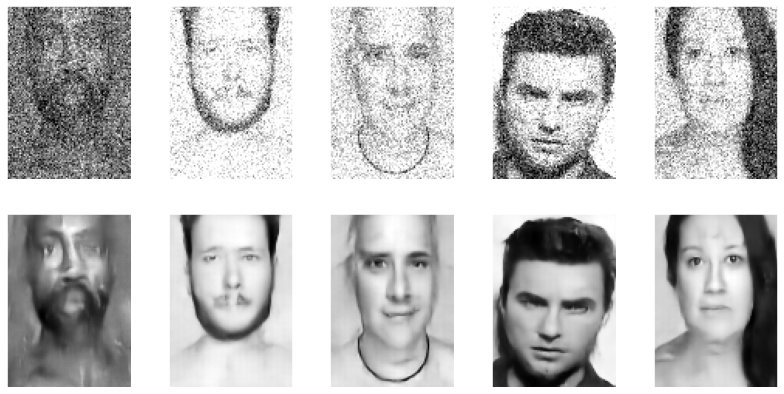

In [ ]:
predTest = modelDenoiseFace.predict(noisedXTrainFace[4700:]) 
predTest = predTest * 255 # представляем в виде значений от 0 до 255
predTest = predTest.astype('uint8') # устанавливаем 8битовый тип
plotImages(noisedXTrainFace[4700:], predTest, shape=(112,80))

In [ ]:
err_Train = [getMSE(xTrain_img[:4700][i], predTrain[i] / 255) for i in range(len(predTrain))]# Возьмем среднеквадратичную ошибку от правильной картинки, и восстановленной, пройдя по 12тыс изображений
err_Test = [getMSE(xTrain_img[4700:][i], predTest[i] / 255) for i in range(len(predTest))]# Возьмем среднеквадратичную ошибку от правильной картинки, и восстановленной, пройдя по 12тыс изображений
print("Средняя ошибка на обучающем наборе MNIST:", sum(err_Train) / xTrain_img[:4700].shape[0]) # взглянем на среднюю ошибку на обучающей выборке
print("Средняя ошибка на тестовом наборе MNIST:", sum(err_Test) /xTrain_img[4700:].shape[0] ) # и на проверочной выборке

Средняя ошибка на обучающем наборе MNIST: 0.0023318843239799056
Средняя ошибка на тестовом наборе MNIST: 0.002470525431182502
